In [50]:
%load_ext autoreload
%autoreload 2

import sys
import os
import jax
import jax.numpy as jnp
from jax import jit
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from jax.typing import ArrayLike

sys.path.append("JohnnyBotSimulator.")


# Dynamically determine the path to the JohnnyBotSimulator directory
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

from Dynamics.JohnnyDynamics import JohnnyDynamics
from Controller.JohnnyControl import JohnnyController
from Estimation.PNT_Estimation import PNT_Estimation

import cvxpy as cp



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
class DynamicallyExtendedUnicycle:

    def __call__(self, state, control):
        return self.drift_dynamics(state) + self.control_matrix(state) @ control

    def drift_dynamics(self, state: ArrayLike) -> tuple:
        '''
        The "drift" term which is the nonlinear term that does not depend on control
        Takes state as an input
        '''
        _, _, theta, v = state
        return jnp.array([v * jnp.cos(theta),
                        v * jnp.sin(theta),
                        0.,
                        0.])
    
    def dynamics2(self, state: ArrayLike, control: ArrayLike) -> tuple:
        A = jnp.array([[0, 0, 1, 0],
                       [0, 0, 0, 1],
                       [0, 0, 0, 0],
                       [0, 0, 0, 0]])
        
        B = jnp.array([[0, 0],
                       [0, 0],
                       [1, 0],
                       [0, 1]])
        
        state_derivative = A @ state + B @ control
        #print("State derivative: ")
        #print(state_derivative)

        
        return state_derivative

    def control_matrix(self, state: ArrayLike):
        '''
        The control matrix B(x) assuming a control affine system.
        In general, it may be state depedent, thus takes state as an input
        Here, we scaled the control input so we have omega and acceleration between [-1, 1]
        '''
        return jnp.array([[0, 0.],
                          [0, 0.],
                          [jnp.pi/2, 0.],
                          [0., 3.]])


dynamics = DynamicallyExtendedUnicycle()

In [73]:
testA = JohnnyController()

In [90]:
def barrier_function(state, r=1):
    x, y, theta, v = state
    return (x-1)**2 + (y-3)**2 - r**2


# linearization of dynamics
def linearize_autodiff3(state, control, func_dynamics): 

    func_x = jit(jax.jacfwd(func_dynamics, argnums=0))
    func_u = jit(jax.jacfwd(func_dynamics, argnums=1))

    A = func_x(state, control)
    B = func_u(state, control)

    return A, B

def lie_derivative(func, vector_field_func, state):
    '''
    func: a function that takes in a state and returns a scalar value.
          i.e., func(state) = scalar
    vector_field_func: a function that takes in a state and returns a
                      vector/matrix. i.e., func(state) = vector/matrix
    state: an array describing the state which is the input to func and
          vector_field_func
    '''

    func_gradx = jax.jacobian(func)
    #func_gradu = jax.jacobian(vector_field_func, argnums=1)
    
    lie = jnp.matmul(func_gradx(state).T, vector_field_func(state))
     
    return lie

def lie_derivative2(func, vector_field_func, state, control):
    '''
    func: a function that takes in a state and returns a scalar value.
          i.e., func(state) = scalar
    vector_field_func: a function that takes in a state and returns a
                      vector/matrix. i.e., func(state) = vector/matrix
    state: an array describing the state which is the input to func and
          vector_field_func
    '''

    func_gradx = jax.jacobian(func)
    #func_gradu = jax.jacobian(vector_field_func, argnums=1)
    state = jnp.array(state)

    lie = jnp.matmul(func_gradx(state).T, vector_field_func(state,control))
     
    return lie

def control_constraint_degree_2(h, dynamics, state, control, class_K_funcs):
    '''
    h: a function that takes in a state and returns a scalar value.
          i.e., h(state) = scalar
    dynamics: the DynamicallyExtendedUnicycle class defined above
    state: an array describing the state which is the input to func and
          vector_field_func
    class_K_funcs: a 2-list of class K function [alpha_func_1, alpha_func_2]

    Compute the coefficients for the CBF/CLF inequality terms, assuming all the terms are moved to the LHS

    Lf2h(z) + LgLfh(z)u + Lfa1h(z) + a2_term


    Returns:
    Lf2h
    LgLfh
    Lfa1h
    a2_term
    '''
    Lfh_func = lambda state: lie_derivative2(h, dynamics.dynamics2, state, control)
    Lfh = lie_derivative2(h, dynamics.dynamics2, state, control)

    alpha1, alpha2 =  class_K_funcs
    alpha1_h_func = lambda state: alpha1(h(state))
    
    Lf2h = lie_derivative2(Lfh_func, dynamics.dynamics2, state, control)
    LgLfh = lie_derivative(Lfh_func, dynamics.control_matrix, state)
    Lfa1h = lie_derivative2(alpha1_h_func, dynamics.dynamics2, state, control)
    a2_term = alpha2(Lfh + alpha1(h(state)))

    return Lf2h, LgLfh, Lfa1h, a2_term

test_state = jnp.array([-1.0, 2.0, 0.1, 1.0])
test_control = jnp.array([0, 0])


#lie_derivative(barrier_function, dynamics.drift_dynamics, test_state)

lie_derivative2(barrier_function, dynamics.dynamics2, test_state, test_control)



Array(-2.4, dtype=float32)

In [91]:
m = 2
gamma1 = 0.05
gamma2 = 10

# use Parameter so the values can updated during the simulation loop as opposed to redefining a new problem each time step






#### put your code here ####






In [94]:
testA.plotter.source= [1,3]
testA.state0 = jnp.array([-2.0, -2.0, 0.1, .1])
alpha1 = lambda x: 2 * x
alpha2 = lambda x: 2 * x
testA.states = [testA.state0]
testA.controls = [testA.control]

# Define system matrices
A = np.array([[0, 0, 1, 0],
                [0, 0, 0, 1],
                [0, 0, 0, 0],
                [0, 0, 0, 0]])

B = np.array([[0, 0],
                [0, 0],
                [1, 0],
                [0, 1]])

# Time horizon
MPC_horizon = 20
testA.tf = 15
time_horizon = int(testA.tf / testA.dt)

testA.time = np.linspace(testA.t0, testA.tf, time_horizon)

testA.desired_states = np.tile(testA.desired_state, (time_horizon, 1))

# Define optimization variables
us = cp.Variable((2, MPC_horizon - 1))  # Control inputs [x_dot_dot, y_dot_dot]
states = cp.Variable((4, MPC_horizon))  # States [x, y, x_dot, y_dot]

state1 = cp.Parameter(4)
# Define optimization variables

db = cp.Parameter(2)
b = cp.Parameter(1)


As = cp.Parameter((4, 4)) # for later
As.project_and_assign(A)
Bs = cp.Parameter((4, 2)) # for later  
Bs.project_and_assign(B)


# Define Q and R matrices
Q = np.diag([2, 2, 1, 1])  # Penalize position error more than velocity error
R = np.diag([0.1, 0.1])  # Penalize control effort

# Define constraints list
constraints = []

# Initial state constraint
constraints.append(states[:, 0] == state1)

constraints.append(b + (db @ us) >= 0)

# Dynamics constraints
for t in range(MPC_horizon - 1):
    constraints.append(states[:, t + 1] == states[:, t] + (A @ states[:, t] + B @ us[:, t]) * testA.dt)
    


# Control input constraints
constraints.append(us[0, :] <= testA.max_acceleration)
constraints.append(us[0, :] >= testA.min_acceleration)
constraints.append(us[1, :] <= testA.max_acceleration)
constraints.append(us[1, :] >= testA.min_acceleration)



# Define the objective function (vectorized)
objective = cp.Minimize(
    cp.sum([cp.quad_form(states[:, t] - testA.desired_states[t, :], Q) for t in range(MPC_horizon)]) +
    cp.sum([cp.quad_form(us[:, t], R) for t in range(MPC_horizon - 1)])
)

# Solve the optimization problem
prob = cp.Problem(objective, constraints)

# Solve the problem iteratively
for i in range(time_horizon-1):

    new_state = testA.states[-1]
    new_control = testA.controls[-1]
    state1.project_and_assign(new_state)
        # b CBF constraint
    print(state1.value)
    # b CBF constraint
    L2fb, LgLfb, Lfa1b, a2_term = control_constraint_degree_2(barrier_function, dynamics, new_state, new_control, [alpha1, alpha2])
    db.project_and_assign(LgLfb)
    b.project_and_assign(L2fb + Lfa1b + a2_term)
    
    # Solve the optimization problem
    result = prob.solve()

    # Check if the problem was solved successfully
    if prob.status == cp.OPTIMAL:
        print(f"Step {i}: Optimization successful!")
        print("Optimal cost:", result)

        # Append the first state and control input to the trajectories
        print("Optimal initial state trajectory:", states.value[:,0])
        print("Optimal state trajectory:", states.value[:,1])
        testA.states.append(states.value[:, 1])  # First state in the horizon
        testA.controls.append(us.value[:, 0])  # First control input in the horizon
    
    else:
        print(f"Step {i}: Optimization failed:", prob.status)
        break

testA.plot()


[-2.  -2.   0.1  0.1]
Step 0: Optimization successful!
Optimal cost: 11492.007395274346
Optimal initial state trajectory: [-2.  -2.   0.1  0.1]
Optimal state trajectory: [-1.999 -1.999  0.12   0.12 ]
[-1.999 -1.999  0.12   0.12 ]
Step 1: Optimization successful!
Optimal cost: 11486.836294583421
Optimal initial state trajectory: [-1.999 -1.999  0.12   0.12 ]
Optimal state trajectory: [-1.9978 -1.9978  0.14    0.14  ]
[-1.9978 -1.9978  0.14    0.14  ]
Step 2: Optimization successful!
Optimal cost: 11481.313982235135
Optimal initial state trajectory: [-1.9978 -1.9978  0.14    0.14  ]
Optimal state trajectory: [-1.9964 -1.9964  0.16    0.16  ]
[-1.9964 -1.9964  0.16    0.16  ]
Step 3: Optimization successful!
Optimal cost: 11475.44075128593
Optimal initial state trajectory: [-1.9964 -1.9964  0.16    0.16  ]
Optimal state trajectory: [-1.9948 -1.9948  0.18    0.18  ]
[-1.9948 -1.9948  0.18    0.18  ]
Step 4: Optimization successful!
Optimal cost: 11469.216913987495
Optimal initial state tra

Final state trajectory: [Array([-2. , -2. ,  0.1,  0.1], dtype=float32), array([-1.999, -1.999,  0.12 ,  0.12 ]), array([-1.9978, -1.9978,  0.14  ,  0.14  ]), array([-1.9964, -1.9964,  0.16  ,  0.16  ]), array([-1.9948, -1.9948,  0.18  ,  0.18  ]), array([-1.993, -1.993,  0.2  ,  0.2  ]), array([-1.991, -1.991,  0.22 ,  0.22 ]), array([-1.9888, -1.9888,  0.24  ,  0.24  ]), array([-1.9864, -1.9864,  0.26  ,  0.26  ]), array([-1.9838, -1.9838,  0.28  ,  0.28  ]), array([-1.981, -1.981,  0.3  ,  0.3  ]), array([-1.978, -1.978,  0.32 ,  0.32 ]), array([-1.9748, -1.9748,  0.34  ,  0.34  ]), array([-1.9714   , -1.9714   ,  0.36     ,  0.3596799]), array([-1.9678    , -1.9678032 ,  0.38      ,  0.37902682]), array([-1.964     , -1.96401293,  0.4       ,  0.39804844]), array([-1.96      , -1.96003245,  0.42      ,  0.41674553]), array([-1.9558    , -1.95586499,  0.44      ,  0.43512115]), array([-1.9514    , -1.95151378,  0.46      ,  0.45317759]), array([-1.9468    , -1.94698201,  0.48      ,

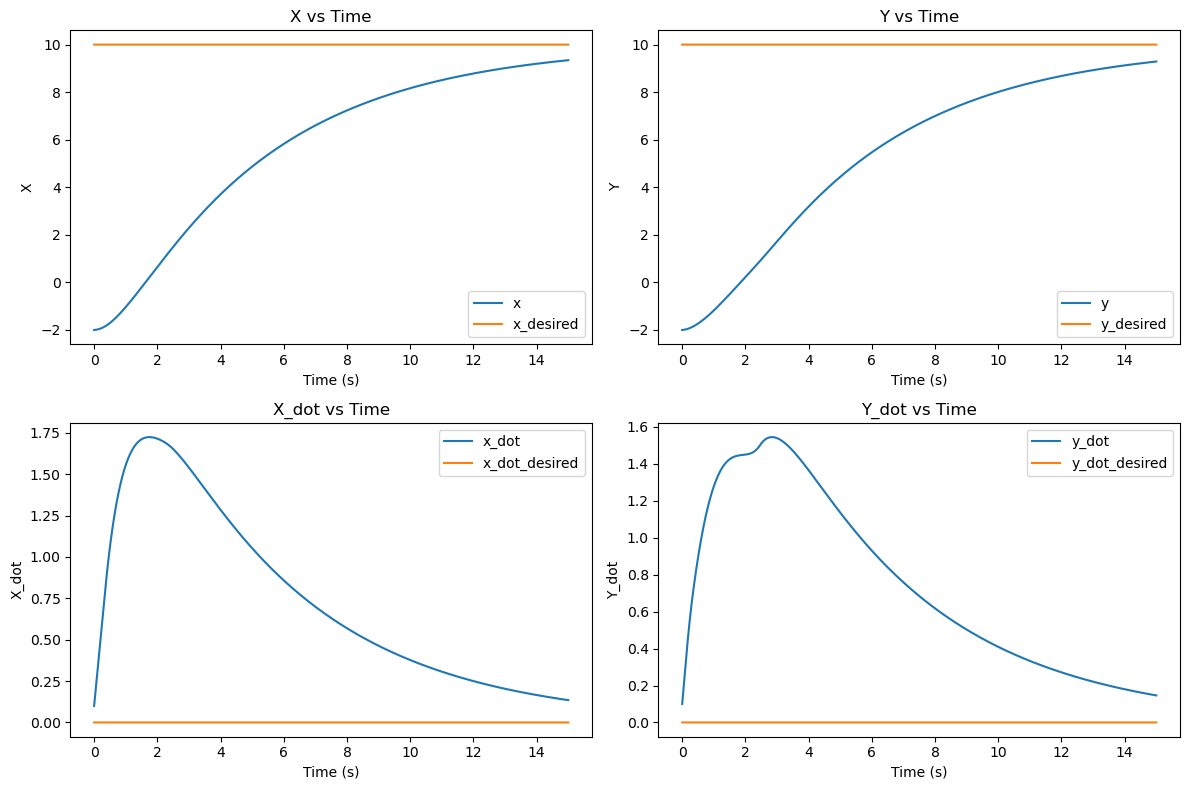

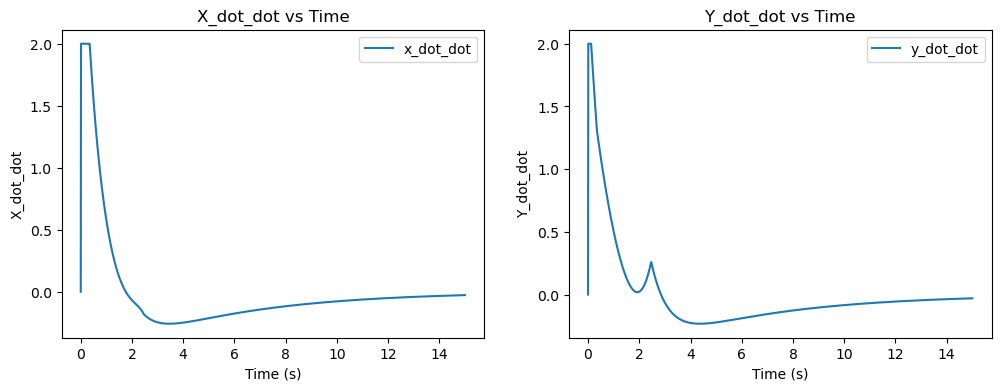

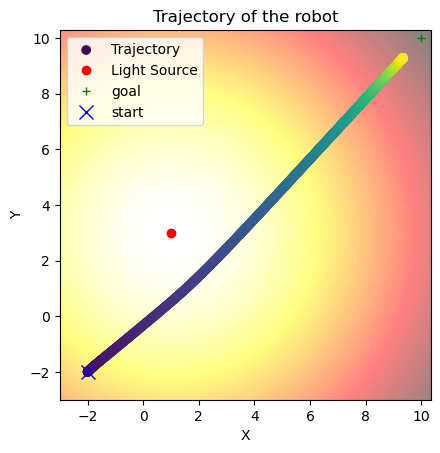

In [95]:
print("Final state trajectory:", testA.states)

testA.plot()

In [ ]:
#variables and parameters
 # Define system matrices




A = np.array([[0, 0, 1, 0],
                [0, 0, 0, 1],
                [0, 0, 0, 0],
                [0, 0, 0, 0]])

B = np.array([[0, 0],
                [0, 0],
                [1, 0],
                [0, 1]])

# Time horizon
time_horizon = int(testA.tf / testA.dt)
testA.time = np.linspace(testA.t0, testA.tf, time_horizon)


testA.kp =1
testA.kd = 1.2
testA.plotter.source= [5,5]
testA.plotter.source_gain= 5
testA.desired_state = jnp.array([0,0,0,0])
testA.state0 = jnp.array([10,10,0,0])


testA.desired_states = np.tile(testA.desired_state, (time_horizon, 1))



# Define obstacle parameters
obstacle_radius = 0.5
obstacle_center = np.array([3, 3, 0, 0])




c:\Users\fatho\anaconda3\lib\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


Optimization successful!
Optimal cost: 125267.60060748804
Optimal control inputs: [[ 2.00000000e+00  2.00000000e+00]
 [ 2.00000000e+00  2.00000000e+00]
 [ 2.00000000e+00  2.00000000e+00]
 ...
 [-9.59009376e-07 -9.59012648e-07]
 [-4.83991134e-07 -4.83992787e-07]
 [ 0.00000000e+00  0.00000000e+00]]
Optimal states: [[-4.46054669e-09 -1.92151356e-09 -2.12158906e-08 -2.69752805e-09]
 [-9.12548876e-09 -3.86224190e-09  1.99999576e-02  1.99999946e-02]
 [ 1.98527466e-04  1.99994178e-04  3.99999539e-02  3.99999920e-02]
 ...
 [ 9.99999517e+00  9.99999517e+00  4.85430247e-06  4.85431967e-06]
 [ 9.99999522e+00  9.99999522e+00  4.84471238e-06  4.84472955e-06]
 [ 9.99999527e+00  9.99999527e+00  4.83987247e-06  4.83988962e-06]]
plotting


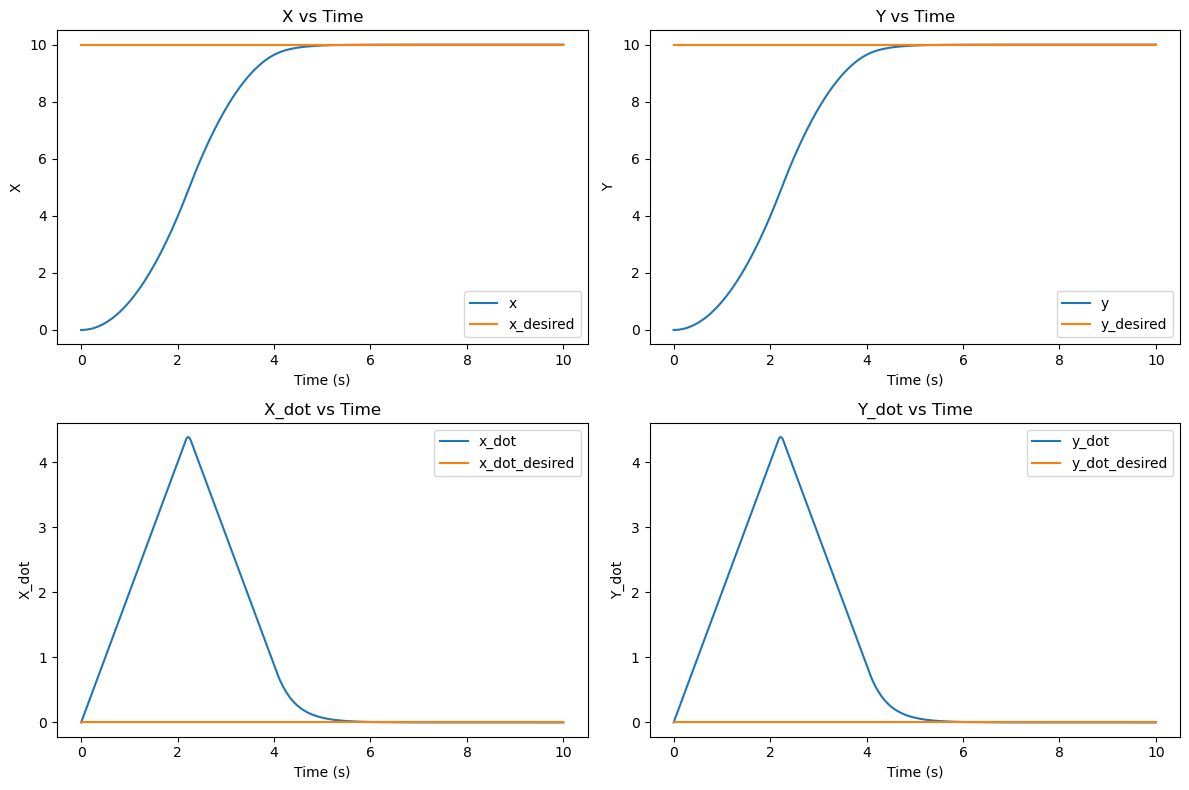

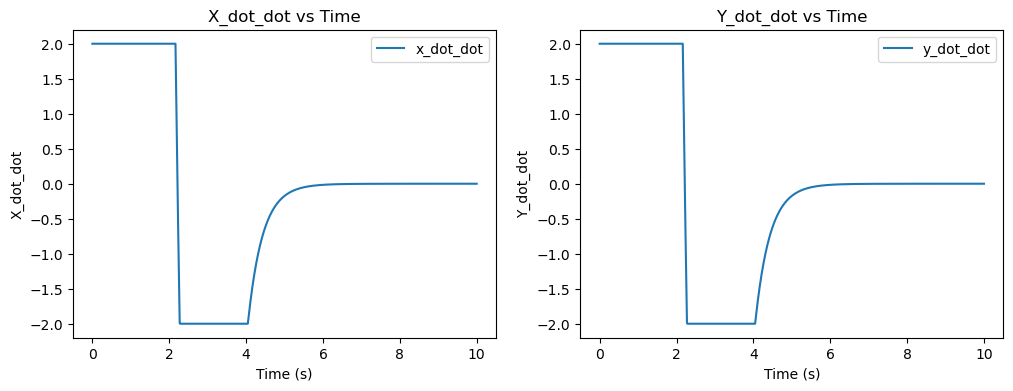

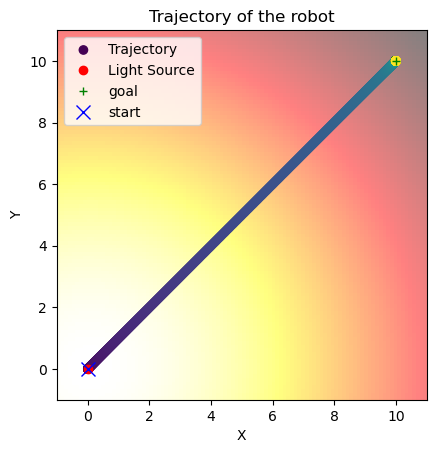

In [29]:
# Define optimization variables
us = cp.Variable((2, time_horizon))  # Control inputs [x_dot_dot, y_dot_dot]
states = cp.Variable((4, time_horizon))  # States [x, y, x_dot, y_dot]
delta = cp.Variable(1)
gamma = cp.Variable(1)


# Define Q and R matrices
Q = np.diag([2, 2, 1, 1])  # Penalize position error more than velocity error
R = np.diag([0.1, 0.1])  # Penalize control effort

# Define constraints
constraints = []

# Initial state constraint
constraints.append(states[:, 0] == testA.state0)




# Dynamics constraints
for t in range(time_horizon - 1):
    constraints.append(states[:, t + 1] == states[:, t] + (A @ states[:, t] + B @ us[:, t])*testA.dt)
    constraints.append(states[0,t + 1] + delta >= 5)
    

# Control input constraints
constraints.append(us[0, :] <= testA.max_acceleration)
constraints.append(us[0, :] >= testA.min_acceleration)
constraints.append(us[1, :] <= testA.max_acceleration)
constraints.append(us[1, :] >= testA.min_acceleration)


# Define the objective function
 # Define the objective function (vectorized)

objective = cp.Minimize(
            cp.sum([cp.quad_form(states[:, t] - testA.desired_states[t, :], Q) for t in range(time_horizon)]) +
            cp.sum([cp.quad_form(us[:, t], R) for t in range(time_horizon - 1)]) + 1e4*delta
        )




# Solve the optimization problem
prob = cp.Problem(objective, constraints)
result = prob.solve(solver=cp.ECOS)

# Check if the problem was solved successfully
if prob.status == cp.OPTIMAL:
    print("Optimization successful!")
    print("Optimal cost:", result)
    print("Optimal control inputs:", us.value.T)
    print("Optimal states:", states.value.T)
    testA.states = states.value.T
    testA.controls = us.value.T  
else:
    print("Optimization failed:", prob.status)
testA

testA.plot()
plt.show()
